In [900]:
import json, os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

### Here's a JSON Reader Function

In [21]:
def read_axe_jsons(axe_num):
    with open('axe_listings/%s' % (axe_num), "r") as read_file:
        listing = json.load(read_file)
    with open('axe_specs/%s' % (axe_num), "r") as read_file:
        specs = json.load(read_file)
    return {'listing': listing, 'specs': specs}

### Here's a Guitar (Axe) Class with Lots of Attributes (Features)

In [907]:
class Axe:
    def __init__(self, axe_num=None):
        self.id = axe_num
        self.__body = read_axe_jsons("%s" % (axe_num))
        self.price_usd = float(self.__body['listing']['sellingStatus'][0]['convertedCurrentPrice'][0]['__value__'])
        self.title = self.__body['listing']['title'][0]
        self.market = self.__body['listing']['globalId'][0]
        self.pic = self.__body['listing']['galleryURL'][0]
        self.pic_big = self.__body['listing']['pictureURLLarge'][0]
        self.url = self.__body['listing']['viewItemURL'][0]
        self.pay_method = self.__body['listing']['paymentMethod'][0]
        self.autopay = self.__body['listing']['autoPay'][0] == 'true'
        self.country_seller = self.__body['listing']['country'][0]
        self.ship_type = self.__body['listing']['shippingInfo'][0]['shippingType'][0]
        self.ship_worldwide = self.__body['listing']['shippingInfo'][0]['shipToLocations'][0] == 'Worldwide'
        self.ship_expedite = self.__body['listing']['shippingInfo'][0]['expeditedShipping'][0] == 'true'
        self.ship_one_day = self.__body['listing']['shippingInfo'][0]['oneDayShippingAvailable'][0] == 'true'
        self.ship_handling_time = int(self.__body['listing']['shippingInfo'][0]['handlingTime'][0])
        self.zip = self.__body['listing'].get('postalCode')
        self.best_offer = self.__body['listing']['listingInfo'][0]['bestOfferEnabled'][0] == 'true'
        
        self.start_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['startTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        self.end_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['endTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        
        self.__duration = (self.end_time - self.start_time)
        self.duration = round(float(self.__duration.days*24) + float(self.__duration.seconds/60/60), 2)
        
        self.returns = self.__body['listing']['returnsAccepted'][0] == 'true'
        self.multi = self.__body['listing']['isMultiVariationListing'][0] == 'true'
        self.top_rated = self.__body['listing']['topRatedListing'][0] == 'true'
        
        # End Generic Section // Begin Specs Section:
        
        self.description = self.__body['specs']['Description']
        self.pic_quantity = len(self.__body['specs']['PictureURL'])
        self.seller_feedback_score = float(self.__body['specs']['Seller']['FeedbackScore'])
        self.seller_positive_percent = float(self.__body['specs']['Seller']['PositiveFeedbackPercent'])
        self.subtitle = self.__body['specs'].get('Subtitle')
        self.condition_description = self.__body['specs'].get('ConditionDescription')
        
        # Niche niche specifics:
        
        if self.returns:
            if self.__body['specs']['ReturnPolicy'].get('ReturnsWithin').split()[1] == 'Days':
                self.returns_time = int(self.__body['specs']['ReturnPolicy'].get('ReturnsWithin').split()[0])
        else: self.returns_time = None
            
        # Very ultra niche specifics, more ducking required:
        
        if self.__body['specs'].get('ItemSpecifics'):
            self.__attrs = {prop['Name']:prop['Value'][0] 
                            for prop in self.__body['specs']['ItemSpecifics']['NameValueList']}
            self.brand = self.__attrs.get('Brand')
            self.model = self.__attrs.get('Model')
            
            if self.__attrs.get('Model Year'):
                self.year = self.__attrs.get('Model Year')[:4]
            else: self.year = None
                
            self.material = self.__attrs.get('Body Material')
            self.right_left_hand = self.__attrs.get('Right-/ Left-Handed')
            self.country_manufacture = self.__attrs.get('Country/Region of Manufacture')
            self.body_type = self.__attrs.get('Body Type')
            self.string_config = self.__attrs.get('String Configuration')
            self.color = self.__attrs.get('Body Color')
        else:
            self.__attrs = self.brand = self.model = self.year = None
            self.material = self.right_left_hand = self.country_manufacture = None
            self.body_type = self.string_config = self.color = None    

In [908]:
axe_0 = Axe('axe_143103953119.json')

In [909]:
# axe_0._Axe__body

In [912]:
axe_0.duration

22.91

In [883]:
filenames = [name for name in os.listdir('axe_listings/') if not name.startswith('.')] # Ignore .DS_Store

In [884]:
axes = [Axe(filename) for filename in jsons]

(array([ 7.,  5.,  7.,  2., 14.,  0., 57.,  0.,  0.,  8.]),
 array([1.45833333e-01, 2.41312500e+01, 4.81166667e+01, 7.21020833e+01,
        9.60875000e+01, 1.20072917e+02, 1.44058333e+02, 1.68043750e+02,
        1.92029167e+02, 2.16014583e+02, 2.40000000e+02]),
 <a list of 10 Patch objects>)

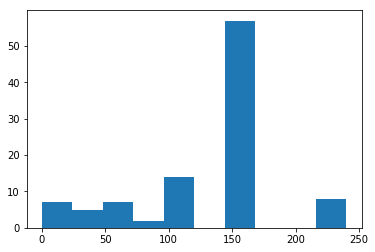

In [901]:
plt.hist([(float(axe.duration.days*24) + float(axe.duration.seconds/60/60)) for axe in axes])